Enable the `autoreload` extension, which will automatically reload the `playfab_manager` module when the source code is updated, using the following magic commands:

In [1]:
%load_ext autoreload
%autoreload 2

Import the `PlayFabManager` class from the `playfab_manager` module and create a `PlayFabManager` instance

In [2]:
from playfab_manager.playfab_manager import PlayFabManager
playfab = PlayFabManager()

Entity token is created


Use the `get_all_players` method of the `PlayFabManager` instance to retrieve a list of all players from the PlayFab:

In [18]:
# NOTE: players are already sorted by last login time
playfab.get_all_players()

Found 191 players
Found 191 players


## Get traces

First, select recent players and get data for them

In [4]:
# Import the datetime module
import datetime

# Get the current time
current_time = datetime.datetime.now(datetime.timezone.utc)

# select the players in the last 24 hours
current_players = [p for p in playfab.all_players if current_time - p.LastLogin <= datetime.timedelta(hours=24)]

# print the last three player ids
[p.PlayerId for p in current_players[:4]]

['22BDA0E2269641A9',
 'AC6A87E6506E72EE',
 'E330FC850A800955',
 '6F9EBD54BAFFBFCC']

Second, get files for each of the player

In [35]:
ids = [p.PlayerId for p in current_players[:4]]
playfab.download_player_files(ids)

Found 3 files for player 22BDA0E2269641A9
Found 3 files for player 22BDA0E2269641A9
Found 3 files for player 22BDA0E2269641A9
Found 3 files for player 22BDA0E2269641A9
Found 2 files for player AC6A87E6506E72EE
Found 2 files for player AC6A87E6506E72EE
Found 2 files for player AC6A87E6506E72EE
Found 2 files for player AC6A87E6506E72EE
Found 2 files for player E330FC850A800955
Found 2 files for player E330FC850A800955
Found 2 files for player E330FC850A800955
Found 2 files for player E330FC850A800955
Found 2 files for player 6F9EBD54BAFFBFCC
Found 2 files for player 6F9EBD54BAFFBFCC
Found 2 files for player 6F9EBD54BAFFBFCC
Found 2 files for player 6F9EBD54BAFFBFCC


Merged files are stored in `TracesPandas`

In [13]:
playfab.all_players[0].TracesPandas.head()

,timestamp,x,z,rotation,signaling,score
0,29999,0,0,0,0,0
1,30099,0,0,351,0,0
2,30199,0,0,341,0,0
3,30299,0,0,331,0,0
4,30399,0,0,321,0,0


In [14]:
playfab.all_players[1].TracesPandas.head()

,timestamp,x,z,rotation,signaling,score
0,31079,0,-125,0,0,0
1,31179,0,-125,0,0,0
2,31279,0,-125,0,0,0
3,31379,0,-125,0,0,0
4,31479,0,-125,0,0,0


In [15]:
playfab.all_players[2].TracesPandas.head()

,timestamp,x,z,rotation,signaling,score
0,32619,120,0,0,0,0
1,32719,120,0,0,0,0
2,32819,120,0,0,0,0
3,32919,120,0,0,0,0
4,33019,120,0,0,0,0


In [16]:
playfab.all_players[3].TracesPandas.head()

,timestamp,x,z,rotation,signaling,score
0,36819,0,120,0,0,0
1,36919,0,120,0,0,0
2,37019,0,120,0,0,0
3,37119,0,120,0,0,0
4,37219,0,120,0,0,0


In [45]:
from utils.utils import merge_traces_dataframes
from visualization.animate_traces import animate_traces

In [36]:
resource = [p.TracesPandas.copy() for p in playfab.all_players[:4] if p.IsResource][0]
players = [p.TracesPandas.copy() for p in playfab.all_players[:4] if not p.IsResource]
len(players)

3

In [37]:
df_all = merge_traces_dataframes(players, resource)

In [38]:
df_all.head()

,timestamp_resource,x_resource,z_resource,rotation_resource,signaling_resource,score_resource,time,timestamp_1,x_1,z_1,...,z_2,rotation_2,signaling_2,score_2,timestamp_3,x_3,z_3,rotation_3,signaling_3,score_3
0,29999,0,0,0,0,0,30.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30099,0,0,351,0,0,30.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30199,0,0,341,0,0,30.2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30299,0,0,331,0,0,30.3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30399,0,0,321,0,0,30.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
server_id = playfab.all_players[0].ServerID
filename = server_id + "_traces.csv"
df_all.to_csv(filename, index=False)

In [42]:
df_all.fillna(method="bfill").head()

,timestamp_resource,x_resource,z_resource,rotation_resource,signaling_resource,score_resource,time,timestamp_1,x_1,z_1,...,z_2,rotation_2,signaling_2,score_2,timestamp_3,x_3,z_3,rotation_3,signaling_3,score_3
0,29999,0,0,0,0,0,30.0,31079.0,0.0,-125.0,...,0.0,0.0,0.0,0.0,36819.0,0.0,120.0,0.0,0.0,0.0
1,30099,0,0,351,0,0,30.1,31079.0,0.0,-125.0,...,0.0,0.0,0.0,0.0,36819.0,0.0,120.0,0.0,0.0,0.0
2,30199,0,0,341,0,0,30.2,31079.0,0.0,-125.0,...,0.0,0.0,0.0,0.0,36819.0,0.0,120.0,0.0,0.0,0.0
3,30299,0,0,331,0,0,30.3,31079.0,0.0,-125.0,...,0.0,0.0,0.0,0.0,36819.0,0.0,120.0,0.0,0.0,0.0
4,30399,0,0,321,0,0,30.4,31079.0,0.0,-125.0,...,0.0,0.0,0.0,0.0,36819.0,0.0,120.0,0.0,0.0,0.0


KeyError: 'x_0'

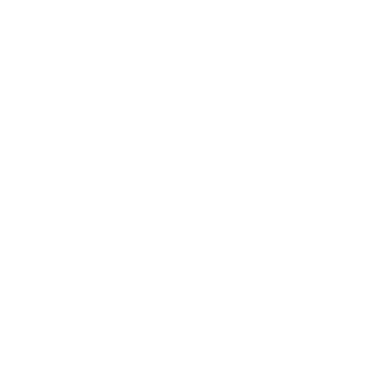

In [46]:
filename = server_id + "_traces.gif"
df_filled = df_all.fillna(method="bfill")

# valid_times = np.logical_and(df_filled.notna()["x_1"], df_filled.notna()["x_2"])
# valid_times = np.logical_and(valid_times, df_filled.notna()["x_3"])
# df_filled.loc[valid_times, :][:1000]

animate_traces(df_filled[:1000], n_players = len(players), save=True, filename=filename)